---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
jupyter: python3
---

# Experiment 1004

In [1]:
import numpy as np
import os
from math import inf
import numpy as np
import warnings
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from spotpython.hyperdict.light_hyper_dict import LightHyperDict
from spotpython.fun.hyperlight import HyperLight
from spotpython.utils.init import (fun_control_init, surrogate_control_init, design_control_init)
from spotpython.utils.eda import print_res_table
from spotpython.hyperparameters.values import set_hyperparameter
from spotpython.spot import Spot
from math import inf
warnings.filterwarnings("ignore")

Seed set to 123


## Creating the Data 

In [2]:
from spotpython.data.manydataset import ManyToManyDataset

# epochs = 2000
# seeds = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
data = pd.read_csv("/Users/bartz/workspace/schu25a_netgen_gecco/data/data_man_tca88.csv")
data["source_file"] = ["tca88"] * len(data)

In [3]:
def load_data(data,
              input_features=['V tot V red [m³/s]'], 
              target= 'PI tot V [-]' ,
              drop = ['Bereich u2red','source_file'],
              group_by='Bereich u2red',
              feature_scaling=None, 
              target_scaling=None, 
              create_dataset=True, 
              dataset_type='many_to_many'):

    if feature_scaling is not None:
        data[input_features] = feature_scaling.fit_transform(data[input_features])
    
    if target_scaling is not None:
        data[target] = target_scaling.fit_transform(data[target])    
    
    if create_dataset == False:
        return data
    else:
        groups = []
        groups_name = []
        data_groups = data.groupby(group_by)

    for name, group in data_groups:
        groups.append(group)
        groups_name.append(name)
    
    if dataset_type == 'many_to_many':
        return ManyToManyDataset(groups, target=target, drop=drop), data
    elif dataset_type == "many_to_one":
        return ManyToOneDataset(groups, target=target, drop=drop), data
kennlinienfelder = data.groupby("source_file")
pred_dict = {}

seeds = [42]
for kennlinienfeld in kennlinienfelder:
    print(f"kennlinienfeld: {kennlinienfeld[0]}")
    data_name = kennlinienfeld[0]
    print(data_name)
    ds, data = ds, _ = load_data(kennlinienfeld[1], 
                                input_features=['PI tot V [-]' ], 
                                target='V tot V red [m³/s]',
                                drop = ['source_file', "Bereich u2red"],
                                group_by="Bereich u2red",
                                # feature_scaling=MinMaxScaler()
                                )
    
    pred_dict[data_name] = {}

    for seed in seeds:
        print(f"seed: {seed}")
        # seed_everything(seed)
        g = torch.Generator()
        g.manual_seed(seed)
        
        pred_dict[data_name][seed] = {}
        pred_dict[data_name][seed]['x'] = []
        pred_dict[data_name][seed]['y_hat'] = []
        pred_dict[data_name][seed]['y'] = []
        pred_dict[data_name][seed]['mape'] = []
        pred_dict[data_name][seed]['rmse'] = []
        
        # Create indices for the split
        indices = list(range(len(ds)))        
        for i in indices:
            test_indices = [indices[i]]
            train_indices = [index for index in indices if index != test_indices[0]]
            
            train_dataset = torch.utils.data.Subset(ds, train_indices)
            test_dataset = torch.utils.data.Subset(ds, test_indices)

kennlinienfeld: tca88
tca88
seed: 42


## Preparing the spotpython Run

In [4]:
fun_control=fun_control_init(
    penalty_NA=200,
    ocba_delta=1,
    TENSORBOARD_CLEAN=False,
    tensorboard_log=False,
    accelerator="cpu",
    collate_fn_name="PadSequenceManyToMany",
    show_config=True,
    verbosity=1,
    save_experiment=True,
    save_result=True,
    PREFIX="1004",
    fun_evals=inf,
    fun_repeats=2,
    max_time=360,
    data_full_train = train_dataset,
    data_val=test_dataset,
    data_test=test_dataset,
    shuffle_train=False,
    shuffle_val=False,    
    core_model_name="light.regression.ManyToManyRNNRegressor",
    hyperdict=LightHyperDict,
    log_level=50,
    _L_in=1,
    _L_out=1)

# set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "rnn_units", [6, 12])
set_hyperparameter(fun_control, "fc_units", [6, 12])
set_hyperparameter(fun_control, "epochs", [12 , 16])
set_hyperparameter(fun_control, "batch_size", [1, 3])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [4, 12])
set_hyperparameter(fun_control, "lr_mult", [0.1, 20.0])

design_control = design_control_init(init_size=20, repeats=2)

surrogate_control = surrogate_control_init(log_level=50, noise=True)

fun = HyperLight().fun

spot_tuner = Spot(fun=fun,fun_control=fun_control, design_control=design_control, surrogate_control=surrogate_control)

Seed set to 123


module_name: light
submodule_name: regression
model_name: ManyToManyRNNRegressor
No tensorboard log created.
Experiment saved to 1004_exp.pkl


## Kopieren der Daten auf den HPC-Server

* ` scp 1004_exp.pkl gm:experiment`

## Ausführend der Experimente auf dem HPC-Server

* `conda activate spot312`
* `sbatch ./startSlurm.sh 1004_exp.pkl`

In [ ]:
# Ignore, only local testing:
# from spotpython.utils.file import load_and_run_spot_python_experiment
# from spotpython.data.manydataset import ManyToManyDataset
# load_and_run_spot_python_experiment(filename="1003_exp.pkl")

In [7]:
# Ignore, only local testing:
# res = spot_tuner.run()

## Laden der Resultate vom Remote Server

*  `scp gm:experiment/1004_res.pkl .`

In [5]:
from spotpython.utils.file import load_result
from spotpython.data.manydataset import ManyToManyDataset
PREFIX = "1003"
spot_tuner = load_result(PREFIX)

Loaded experiment from 1003_res.pkl


| name         | type   | default   |   lower |   upper | tuned                | transform             |   importance | stars   |
|--------------|--------|-----------|---------|---------|----------------------|-----------------------|--------------|---------|
| rnn_units    | int    | 3         |     6.0 |    12.0 | 7.0                  | transform_power_2_int |         4.96 | *       |
| fc_units     | int    | 8         |     6.0 |    12.0 | 11.0                 | transform_power_2_int |         0.13 | .       |
| epochs       | int    | 10        |     6.0 |     8.0 | 7.0                  | transform_power_2_int |         0.14 | .       |
| batch_size   | int    | 10        |     1.0 |     3.0 | 2.0                  | transform_power_2_int |         0.13 | .       |
| act_fn       | factor | ReLU      |     0.0 |     5.0 | ELU                  | None                  |         0.13 | .       |
| optimizer    | factor | SGD       |     0.0 |    11.0 | AdamW                | None     

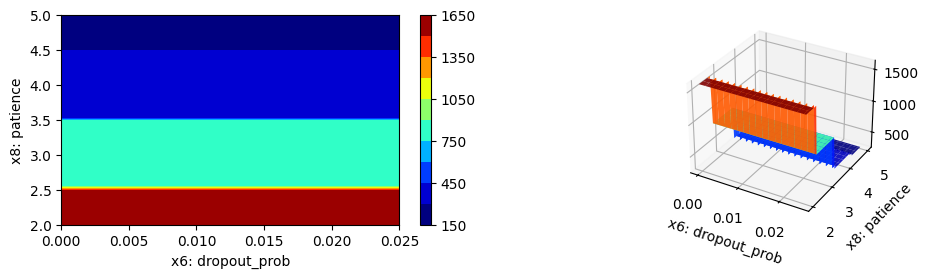

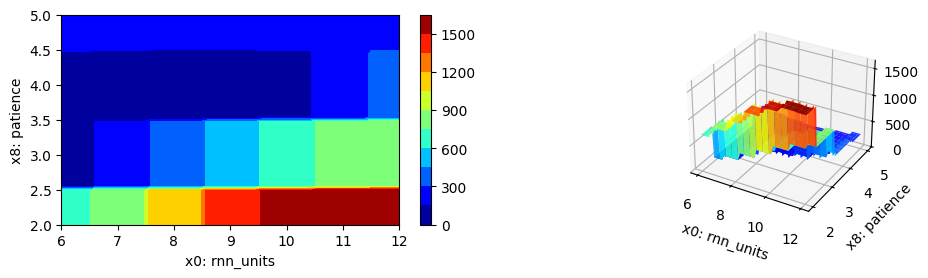

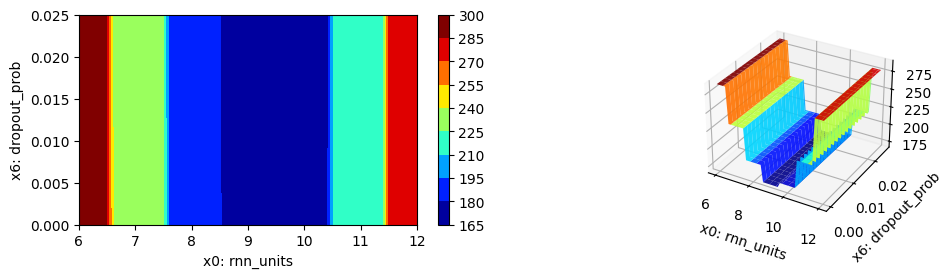

In [6]:
print_res_table(spot_tuner)
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

In [12]:
from spotpython.hyperparameters.values import get_tuned_architecture
get_tuned_architecture(spot_tuner)

{'rnn_units': 128,
 'fc_units': 2048,
 'epochs': 128,
 'batch_size': 4,
 'act_fn': ELU(),
 'optimizer': 'AdamW',
 'dropout_prob': 0.023810468001851916,
 'lr_mult': 1.0354446885074793,
 'patience': 16}